In [284]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random

### invalid

In [285]:
n = 500
T = 1
d = 2
B = 100  # Number of p-values to compute

# Generate an SBM
As, tau,P_t = make_iid(n, T, iid_prob=0.9)
A_obs = As[0]

In [286]:
def edgelist_jackknife(A, B):
    """
    Pick a random entry and set it to zero
    """
    n = A.shape[0]
    A_star = np.zeros((B, n, n))

    for i in range(B):
        A_star[i] = A.copy()
        for j in range(3):
            idx = np.random.choice(n, size=2, replace=True)
            A_star[i][idx[0], idx[1]] = 0
            A_star[i][idx[1], idx[0]] = 0

    return A_star

# Bootstrap
A_jk = edgelist_jackknife(A_obs, B=B)

# Testing
p_vals = []
for i in range(B):
    A_jk_sample = A_jk[i, :, :]

    # Embed the observed and bootstrapped graphs
    Y_unf = UASE([A_obs, A_jk_sample], d=d)

    # Compute the p-value
    p_val = test_temporal_displacement_two_times(Y_unf, n)
    p_vals.append(p_val)


In [ ]:
p_vals_invalid = p_vals  

# p-values for Invalid Resample
# Provided code
p_hat_list = p_vals_invalid
roc = []
alphas = []

for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"(a) Invalid Resample", size=18)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()

# plt.savefig("InvalidResampleEx.png", facecolor='w')

plt.show()

### perfect

In [288]:
# Run a k-NN on a K=2 community SBM

n = 300
T = 1
d = 2

# Generate an SBM
# As, tau = make_iid(n, T, iid_prob=0.9)

K = 2
As, tau, _ = make_temporal_simple(n, T, K=K) # K community SBM
A_obs = As[0]

In [289]:
yhat = UASE(As, d=d, flat=False)

In [290]:
# run a k-NN on the embedding yhat
n_neighbors = 5

# Here we use Minkowski distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(yhat[0])
distances, indices = nbrs.kneighbors(yhat[0])

In [291]:
P_est = P_est_from_A_obs(n, A_obs, n_neighbors, indices)

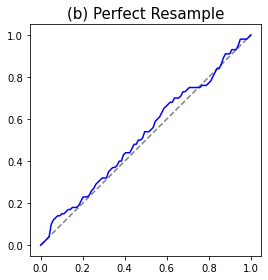

In [294]:
B = 100
p_vals = []
A_boots = []
for i in range(B):
    A_est = make_inhomogeneous_rg(P_est)

    yhat_est = UASE([A_obs,A_est], d=2)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)
    A_boots.append(A_est)

p_vals_perfect = p_vals  # p-values for Perfect Resample

#plot
# Provided code
p_hat_list = p_vals_perfect
roc = []
alphas = []

for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='b')

# Set title and aspect ratio
plt.title(f"(b) Perfect Resample", size=15)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()

# plt.savefig("PerfectResampleEx.png", facecolor='w')

plt.show()

### conservative

  0%|          | 0/1 [00:00<?, ?it/s]

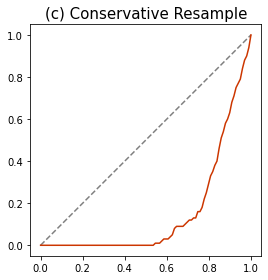

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


In [296]:
# n_neighbors_to_try = [5] + list(np.linspace(n//4, n, 20).astype(int))
n_neighbors_to_try = [100]

powers = []
avg_dist_errors = []
for n_neighbors in tqdm(n_neighbors_to_try):

    # Generate graphs -------------------------------
    n = 100
    T = 1
    d = 2
    K = 2
    As, tau, _ = make_temporal_simple(n, T, K=K) # K community SBM
    A_obs = As[0]


    # Embed the graphs -------------------------------  
    yhat = UASE(As, d=d, flat=False)

    # # run a k-NN on the embedding yhat
    # n_neighbors = 5

    # Here we use Minkowski distance
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(yhat[0])
    distances, indices = nbrs.kneighbors(yhat[0])

    # Estimate the P matrix -------------------------------
    P_est = P_est_from_A_obs(n, A_obs, n_neighbors=n_neighbors, indices=indices)

    # Bootstrap -----------------------------------------
    B = 100
    p_vals = []
    A_boots = []
    for i in range(B):
        A_est = make_inhomogeneous_rg(P_est)

        yhat_est = UASE([A_obs,A_est], d=2)
        p_val = test_temporal_displacement_two_times(yhat_est, n)
        p_vals.append(p_val)
        A_boots.append(A_est)

    p_vals_conservative = p_vals  # p-values for Conservative Resample

    #plot
    # Provided code
    p_hat_list = p_vals
    roc = []
    alphas = []

    for alpha in np.linspace(0, 1, 100):
        alphas.append(alpha)
        num_below_alpha = sum(p_hat_list < alpha)
        roc_point = num_below_alpha / len(p_hat_list)
        roc.append(roc_point)

    # Get the power at the 5% significance level
    power_significance = 0.05
    power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
    power = roc[power_idx]

    plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
    _ = plt.plot(alphas, roc, color='#cc3600')

    # Set title and aspect ratio
    plt.title(f"(c) Conservative Resample", size=15)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.tight_layout()

    # plt.savefig("ConservativeResampleEx.png", facecolor='w')

    plt.show()
 

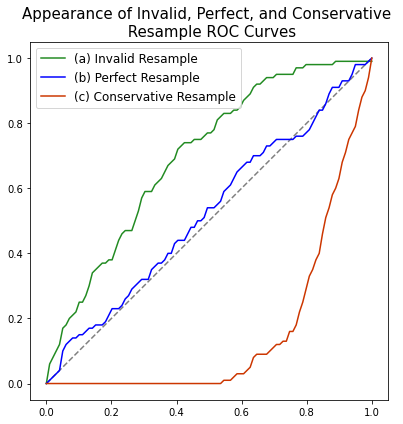

In [297]:
def compute_roc(p_vals):
    """Compute ROC curve from p-values."""
    roc = []
    alphas = []

    for alpha in np.linspace(0, 1, 100):
        alphas.append(alpha)
        num_below_alpha = sum(p_vals < alpha)
        roc_point = num_below_alpha / len(p_vals)
        roc.append(roc_point)

    return alphas, roc

# Compute ROC curves
alphas_invalid, roc_invalid = compute_roc(np.array(p_vals_invalid))
alphas_perfect, roc_perfect = compute_roc(np.array(p_vals_perfect))
alphas_conservative, roc_conservative = compute_roc(np.array(p_vals_conservative))

# Plot all ROC curves on the same plot
plt.figure(figsize=(6, 6))  # Square figure

# Plot the reference diagonal line
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", color="grey")

# Plot each ROC curve
plt.plot(alphas_invalid, roc_invalid, color='#228B22', label="(a) Invalid Resample")
plt.plot(alphas_perfect, roc_perfect, color='b', label="(b) Perfect Resample")
plt.plot(alphas_conservative, roc_conservative, color='#cc3600', label="(c) Conservative Resample")

# Set title, labels, and legend
plt.title("Appearance of Invalid, Perfect, and Conservative \n Resample ROC Curves", size=15)
plt.gca().set_aspect('equal', adjustable='box')  # Ensure square plot
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig("oneplot_example_invalid_perfect_conservative.png", facecolor='w')

# Display the plot
plt.show()
